In [ ]:
!pip install tensorflow keras
!pip install opencv-python


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import random
import shutil
import os

# Define the base path for the dataset
base_dir = '/content/drive/MyDrive/Corrosion'
rust_dir = os.path.join(base_dir, 'rust')
no_rust_dir = os.path.join(base_dir, 'no rust')

# Create directories for train and test sets
os.makedirs('/content/drive/MyDrive/Corrosion/train/rust', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Corrosion/train/no rust', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Corrosion/test/rust', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Corrosion/test/no rust', exist_ok=True)

# List all images in each directory
rust_images = os.listdir(rust_dir)
no_rust_images = os.listdir(no_rust_dir)

# Randomly select 10 images each for the test set
test_rust = random.sample(rust_images, 10)
test_no_rust = random.sample(no_rust_images, 10)

# Copy images to the respective train and test directories
for img in rust_images:
    src_path = os.path.join(rust_dir, img)
    if img in test_rust:
        shutil.copy(src_path, '/content/drive/MyDrive/Corrosion/test/rust/')
    else:
        shutil.copy(src_path, '/content/drive/MyDrive/Corrosion/train/rust/')

for img in no_rust_images:
    src_path = os.path.join(no_rust_dir, img)
    if img in test_no_rust:
        shutil.copy(src_path, '/content/drive/MyDrive/Corrosion/test/no rust/')
    else:
        shutil.copy(src_path, '/content/drive/MyDrive/Corrosion/train/no rust/')



In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Corrosion/train/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Corrosion/test/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 750 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [5]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [7]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // 32), # Ensure steps_per_epoch is at least 1
    epochs=10,
    validation_data=test_generator,
    validation_steps=max(1, test_generator.samples // 32) # Ensure validation_steps is at least 1
)


Epoch 1/10
23/23 [==============================] - 37s 2s/step - loss: 0.5626 - accuracy: 0.7312 - val_loss: 0.4164 - val_accuracy: 0.8000
Epoch 2/10
23/23 [==============================] - 40s 2s/step - loss: 0.4480 - accuracy: 0.7869 - val_loss: 0.3422 - val_accuracy: 0.8500
Epoch 3/10
23/23 [==============================] - 37s 2s/step - loss: 0.4166 - accuracy: 0.8287 - val_loss: 0.3087 - val_accuracy: 0.9000
Epoch 4/10
23/23 [==============================] - 37s 2s/step - loss: 0.4092 - accuracy: 0.8245 - val_loss: 0.3027 - val_accuracy: 0.9000
Epoch 5/10
23/23 [==============================] - 40s 2s/step - loss: 0.3795 - accuracy: 0.8440 - val_loss: 0.2964 - val_accuracy: 1.0000
Epoch 6/10
23/23 [==============================] - 37s 2s/step - loss: 0.3578 - accuracy: 0.8468 - val_loss: 0.2891 - val_accuracy: 0.9500
Epoch 7/10
23/23 [==============================] - 41s 2s/step - loss: 0.3917 - accuracy: 0.8357 - val_loss: 0.2879 - val_accuracy: 0.9000
Epoch 8/10
23/23 [==

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy*100:.2f}%')


1/1 [==============================] - 0s 488ms/step - loss: 0.2463 - accuracy: 0.9000
Test Accuracy: 90.00%


In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 model without the top layer
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers of the ResNet50 base model
for layer in resnet_base.layers:
    layer.trainable = False

# Build the new model
resnet_model = Sequential([
    resnet_base,  # Add the ResNet50 base model
    Flatten(),  # Flatten the output of ResNet50
    Dense(128, activation='relu'),  # Add a fully connected layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
resnet_model.summary()

# Train the model
history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // 32), # Ensure steps_per_epoch is at least 1
    epochs=10,  # Using 10 epochs as suggested
    validation_data=test_generator,
    validation_steps=max(1, test_generator.samples // 32) # Ensure validation_steps is at least 1
)

# Evaluate the ResNet50 model
loss, accuracy = resnet_model.evaluate(test_generator)
print(f'Test Accuracy with ResNet50: {accuracy * 100:.2f}%')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               6553728   
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 30141569 (114.98 MB)
Trainable params: 6553857 (25.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/10
23/23 [==============================] - 84s 3s/step - loss: 0.7059 - accuracy: 0.5292 - val_loss: 0.7193 - val_accuracy: 0.500

Results for CNN Model:
1/1 [==============================] - 1s 1s/step
Overall Accuracy: 40.00%
                                             Filename True Label  \
0                        no rust/002_yoamnba2.wdq.jpg    no rust   
1                        no rust/016_0fop1kjm.yyx.jpg    no rust   
2                        no rust/031_s0b2izj1.evt.jpg    no rust   
3                        no rust/036_bv2no3zc.0o4.jpg    no rust   
4   no rust/CA-560759R-6232016-FLD-DC-VIC-005-G21-...    no rust   
5                   no rust/IMG_0402_mrn1uhtc.z33.jpg    no rust   
6                   no rust/RIMG0747_m2cuhupn.g5b.jpg    no rust   
7                   no rust/RIMG0785_vqf11bnb.auw.jpg    no rust   
8                   no rust/RIMG1463_lgn2ojtj.guh.jpg    no rust   
9                   no rust/RIMG2053_3d1rmyzs.mmx.jpg    no rust   
10                          rust/017_qg4of44j.ruw.jpg       rust   
11                          rust/191_ootfvovz.jmr.jpg       rust   
12                

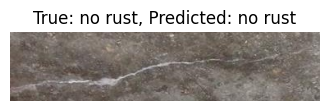

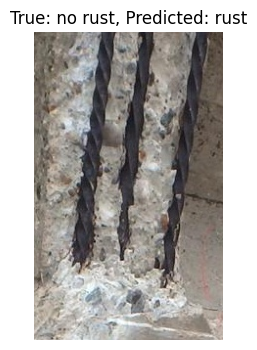

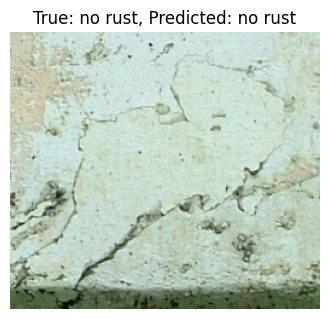

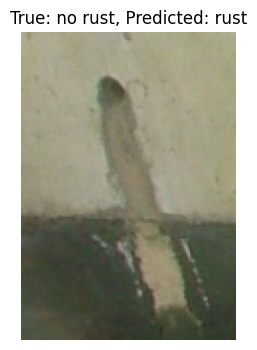

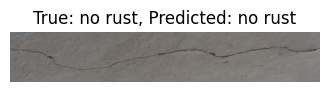

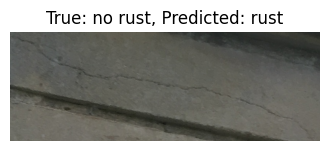

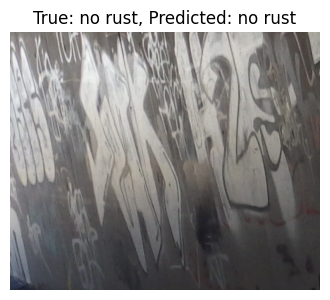

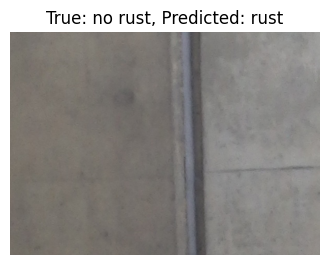

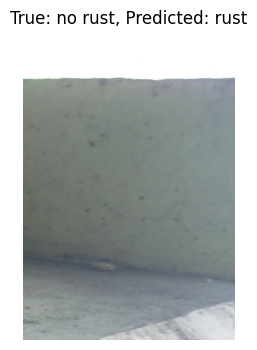

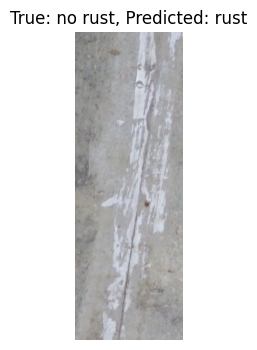

Results for ResNet50 Model:
1/1 [==============================] - 6s 6s/step
Overall Accuracy: 60.00%
                                             Filename True Label  \
0                        no rust/002_yoamnba2.wdq.jpg    no rust   
1                        no rust/016_0fop1kjm.yyx.jpg    no rust   
2                        no rust/031_s0b2izj1.evt.jpg    no rust   
3                        no rust/036_bv2no3zc.0o4.jpg    no rust   
4   no rust/CA-560759R-6232016-FLD-DC-VIC-005-G21-...    no rust   
5                   no rust/IMG_0402_mrn1uhtc.z33.jpg    no rust   
6                   no rust/RIMG0747_m2cuhupn.g5b.jpg    no rust   
7                   no rust/RIMG0785_vqf11bnb.auw.jpg    no rust   
8                   no rust/RIMG1463_lgn2ojtj.guh.jpg    no rust   
9                   no rust/RIMG2053_3d1rmyzs.mmx.jpg    no rust   
10                          rust/017_qg4of44j.ruw.jpg       rust   
11                          rust/191_ootfvovz.jmr.jpg       rust   
12           

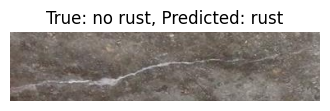

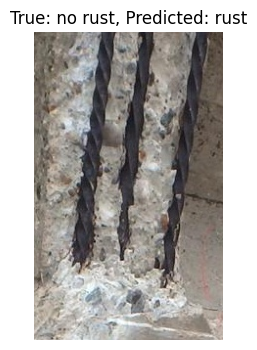

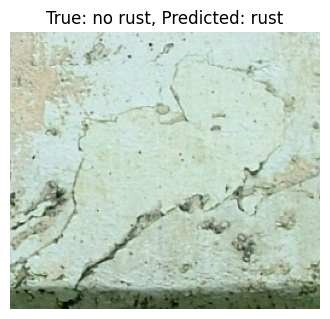

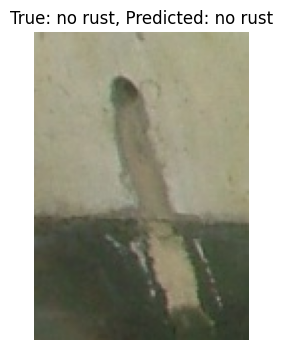

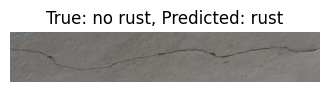

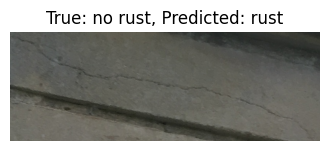

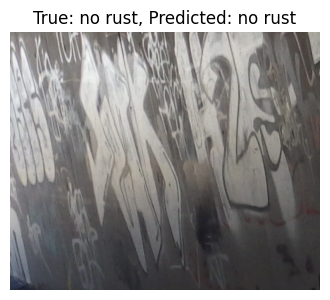

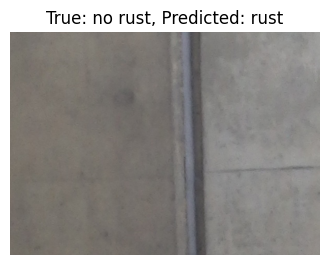

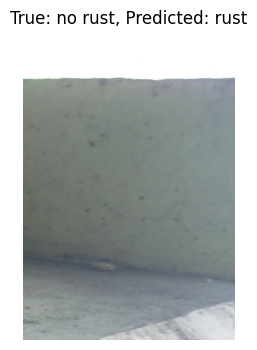

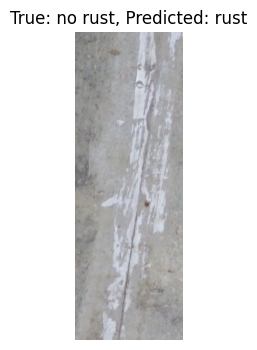

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to make predictions and visualize results
def visualize_predictions(model, generator, class_labels):
    # Reset the generator to start from the beginning
    generator.reset()

    # Get the filenames, true labels, and predictions
    filenames = generator.filenames
    true_labels = generator.classes
    predictions = model.predict(generator, steps=len(generator), verbose=1)
    predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

    # Create a table to display true vs. predicted labels
    results_df = pd.DataFrame({
        'Filename': filenames,
        'True Label': [class_labels[label] for label in true_labels],
        'Predicted Label': [class_labels[label] for label in predicted_labels]
    })

    # Calculate overall accuracy
    accuracy = np.mean(predicted_labels == true_labels)
    print(f'Overall Accuracy: {accuracy * 100:.2f}%')

    # Display the table
    print(results_df)

    # Visualize the first few images with their predictions
    for i in range(10):  # Display first 10 images as example
        img_path = os.path.join(generator.directory, filenames[i])
        img = plt.imread(img_path)

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f'True: {results_df["True Label"].iloc[i]}, Predicted: {results_df["Predicted Label"].iloc[i]}')
        plt.axis('off')
        plt.show()

    return results_df

# Class labels for the problem
class_labels = {0: 'no rust', 1: 'rust'}

# Predict and visualize results for CNN model
print("Results for CNN Model:")
cnn_results = visualize_predictions(model, test_generator, class_labels)

# Predict and visualize results for ResNet50 model
print("Results for ResNet50 Model:")
resnet_results = visualize_predictions(resnet_model, test_generator, class_labels)


In [12]:
# Save results to CSV files if needed
cnn_results.to_csv('cnn_test_results.csv', index=False)
resnet_results.to_csv('resnet50_test_results.csv', index=False)